# VISUALIZE_EMERGENT
This file is used to visual KL divergence of distributions of emergent characteristics as well as absolute emergent behvaior values. 

The first step is to load the expert trajectories and compute the baseline values.

Then we load the trajectories for the models that we want to examine.

This involves some reshaping of the trajectories, and unnormalizing. 

Finally, we can compute the values we want, and display them.

In [1]:
%matplotlib inline

import collections
import matplotlib.pyplot as plt
import numpy as np 
import os
from scipy.stats import gaussian_kde
from scipy.stats import entropy

import hgail.misc.utils

import utils
import visualize_utils

from copy import deepcopy

In [2]:
def unnormalize(x, mean, std):
    return (x * std) + mean

In [3]:
def filename2label(fn):
    s = fn.find('-') + 1
    e = fn.rfind('.')
    return fn[s:e]

# Expert stuff

In [4]:
expert_filepath = '../../data/trajectories/ngsim_all.h5'

filenames = list(utils.NGSIM_FILENAME_TO_ID.keys())

expert = dict()
for fn in filenames:
    t = filename2label(fn)
    print("fn:", fn, "t:", t)
    expert[t] = utils.load_data(
        expert_filepath, 
        min_length=250, 
        normalize_data=False, 
        clip_std_multiple=10.,
        ngsim_filename=fn
    )

fn: trajdata_i101_trajectories-0805am-0820am.txt t: 0805am-0820am
fn: trajdata_i80_trajectories-0500-0515.txt t: 0500-0515
fn: trajdata_i80_trajectories-0515-0530.txt t: 0515-0530
fn: trajdata_i101_trajectories-0820am-0835am.txt t: 0820am-0835am
fn: trajdata_i80_trajectories-0400-0415.txt t: 0400-0415
fn: trajdata_i101_trajectories-0750am-0805am.txt t: 0750am-0805am


In [5]:
x, names = utils.load_x_feature_names(expert_filepath, 'trajdata_i101_trajectories-0750am-0805am.txt')
observation_indexes = dict([(names[i], i) for i in range(len(names))])
#print(observation_indexes)

In [6]:
print(names)

['relative_offset' 'relative_heading' 'velocity' 'length' 'width'
 'lane_curvature' 'markerdist_left' 'markerdist_right' 'accel' 'jerk'
 'turn_rate_global' 'angular_rate_global' 'turn_rate_frenet'
 'angular_rate_frenet' 'timegap' 'timegap_is_avail' 'time_to_collision'
 'time_to_collision_is_avail' 'is_colliding' 'out_of_lane'
 'negative_velocity' 'distance_road_edge_left' 'distance_road_edge_right'
 'lidar_1' 'lidar_2' 'lidar_3' 'lidar_4' 'lidar_5' 'lidar_6' 'lidar_7'
 'lidar_8' 'lidar_9' 'lidar_10' 'lidar_11' 'lidar_12' 'lidar_13' 'lidar_14'
 'lidar_15' 'lidar_16' 'lidar_17' 'lidar_18' 'lidar_19' 'lidar_20'
 'rangerate_lidar_1' 'rangerate_lidar_2' 'rangerate_lidar_3'
 'rangerate_lidar_4' 'rangerate_lidar_5' 'rangerate_lidar_6'
 'rangerate_lidar_7' 'rangerate_lidar_8' 'rangerate_lidar_9'
 'rangerate_lidar_10' 'rangerate_lidar_11' 'rangerate_lidar_12'
 'rangerate_lidar_13' 'rangerate_lidar_14' 'rangerate_lidar_15'
 'rangerate_lidar_16' 'rangerate_lidar_17' 'rangerate_lidar_18'
 'rangera

In [7]:
# modifies expert_values and bounds in place
def compute_expert_for_timeperiod(obser_attrs, key_for_attr, expert_values, expert_bounds, expert,
                                  time_period='0750am-0805am'):
    expert_values[time_period] = dict()
    expert_bounds[time_period] = dict()
    t = time_period # so i dont have to write it out every time
    for attr in obser_attrs:
        expert_values[time_period][key_for_attr[attr]] = gaussian_kde(expert[time_period]\
                                                                      ['observations'][:,observation_indexes[attr]])
        #lower = np.percentile(expert[time_period]['observations'][:,observation_indexes[attr]], 1)
        #upper = np.percentile(expert[time_period]['observations'][:,observation_indexes[attr]], 99)
        lower = np.min(expert[time_period]['observations'][:,observation_indexes[attr]])
        upper = np.max(expert[time_period]['observations'][:,observation_indexes[attr]])
        expert_bounds[time_period][key_for_attr[attr]] = (lower, upper)

    # Some specific formatting ones
    expert_values[time_period]['iTTC'] = gaussian_kde(1/expert[time_period]\
                                                      ['observations'][:,observation_indexes['time_to_collision']])
    #lower = np.percentile(1/expert[time_period]['observations'][:,observation_indexes['time_to_collision']], 1)
    #upper = np.percentile(1/expert[time_period]['observations'][:,observation_indexes['time_to_collision']], 99)
    lower = np.min(1/expert[time_period]['observations'][:,observation_indexes['time_to_collision']])
    upper = np.max(1/expert[time_period]['observations'][:,observation_indexes['time_to_collision']])
    expert_bounds[time_period]['iTTC'] = (lower, upper)


In [8]:
observation_attributes = ['accel','turn_rate_global',
                          'velocity', 'jerk', 'time_to_collision', 
                          'distance_road_edge_right', 'distance_road_edge_left']
key_for_attr = {'velocity': 'Speed',
                'jerk': 'Jerk',
                'time_to_collision': 'TTC',
                'distance_road_edge_left': 'dleft',
                'distance_road_edge_right': 'dright',
                'accel': 'Acceleration',
                'turn_rate_global': 'Turn-rate'}

expert_values = dict()
expert_bounds = dict()
timeperiod_labels = [filename2label(fn) for fn in filenames]


for time_period in timeperiod_labels:
    compute_expert_for_timeperiod(observation_attributes, key_for_attr, expert_values, expert_bounds, 
                                  expert, time_period)
    

In [9]:
print(expert_bounds)

{'0820am-0835am': {'iTTC': (0.033333333333333333, 1276.2552473386506), 'Acceleration': (-9.1694780995896341, 19.6527255780126), 'dright': (-2.3457481513705556, 20.482909199293207), 'TTC': (0.00078354232202788572, 30.0), 'Speed': (4.4628430053130104e-05, 30.40344487830156), 'Jerk': (-56.311584929457936, 170.35835764012609), 'Turn-rate': (-0.75255207008845582, 0.68108557836508465), 'dleft': (-2.3049260146309027, 21.966074121207619)}, '0515-0530': {'iTTC': (0.033333333333333333, 7831.5252087421422), 'Acceleration': (-16.849183497722397, 23.892440754049584), 'dright': (-2.9579817710975593, 22.500620147236749), 'TTC': (0.00012768904821805645, 30.0), 'Speed': (1.7446284795667262e-07, 25.305603630314589), 'Jerk': (-137.85622216316327, 164.69245563910255), 'Turn-rate': (-1.0364120745977479, 1.1786323844421152), 'dleft': (-3.006053734904591, 24.210856554510521)}, '0500-0515': {'iTTC': (0.033333333333333333, 5268.1904483364478), 'Acceleration': (-27.417706740970392, 48.263321905873347), 'dright'

# Load model stuff

In [10]:
model_labels = [
    'multiagent_rails_col_off_+2000_1_fine',
    'multiagent_rails_col_off_+2000_2_fine',
    'multiagent_rails_col_off_+2000_3_fine',
    'multiagent_curr_1_fine',
    'multiagent_curr_2_fine',
    'multiagent_curr_3_fine',
    
]
n_itrs = dict([(i, 200) for i in model_labels])
for i in model_labels:
    if 'multi' in i:
        n_itrs[i] = 200



In [11]:
orig_traj_lab_dict = visualize_utils.get_trajs_dict(model_labels)
valdirs, params_filepaths = visualize_utils.get_val_dirs_and_params_paths_d(model_labels, n_itrs)

## traj_lab_dict Structure:

* for each model, a tuple of (trajectories, labels) that are returned from utils.load_trajs_labels()
    
    * trajectories is a list 
    
        * there is a list element for each dataset (e.g. i101_750_805, i101_805_815..., so 6 elements)
        
            * This is determined from the validate run. Each dataset that we generate trajectories for (filenames variable in the main function for validate.py)
        
        * each list element is an ndarry of shape (T,), where T = number of simulations run. 
                * This is determined in validate.py, as run_args.n_multiagent_trajs / args.n_envs. For n_trajs = 10000, n_vehs = 100, T = 100.
        
                * validate.py produces a total of run_args.n_multiagent_trajs trajectories. From each initial sample scene, we simulate 1 trajectory for each agent. Thus, n_vehs trajectories. Therefore, we need to run T simulations. 
         
            * each item in the array is a dictionary, of trajectory 'characteristics'
            
               * a trajectory component is something like, observations, actions:
           
                   * dict_keys(['rewards', 'rmse_t', 'prev_action', 'x', 'observations', 'mean', 'is_colliding', 'actions', 'y', 'log_std', 'rmse_vel', 'rmse_pos', 'phi', 's'])
                  
                   * the values are an array of shape (H, N, K), where H = the env_H (length of a trajectory or number of timesteps). N = number of agents. K is a third dimension, for things like observations (for which K=64). For something like rmse_t, K doesn't exist (array of shape (H, N)).
                   
                   * There is essentially a dictionary for every intial scene that we sampled. 
    
    - labels is a list
    
        * There is also an element for each dataset, like for trajectories. So, 6 in the default case we have.
    
            + ['0750am-0805am', '0805am-0820am', '0820am-0835am', '0400-0415', '0500-0515', '0515-0530']
    
        

In [12]:
# This is where we unnormalize / reshape for the multiagent viz case
# reshape basically flattens each attribute of the trajectory
def reformat_trajectories(traj_lab_dict, length = 200, multi=True, reshape=True, 
                          unnormalize_data=True):
    for i, model in enumerate(model_labels):
        trajs = traj_lab_dict[model][0]
        params = hgail.misc.utils.load_params(params_filepaths[i])
        for timeperiod in trajs:
            for traj in timeperiod:
                if multi:
                    n_veh = traj['observations'].shape[1]
                else:
                    n_veh = 1
                if unnormalize_data:
                    for j in range(n_veh):
                        traj['observations'][:,j] = unnormalize(
                            traj['observations'][:,j], 
                            params['normalzing']['obs_mean'],
                            np.sqrt(params['normalzing']['obs_var'])
                        )
                if reshape:
                    for attr in traj.keys():
                        shape = traj[attr].shape
                        if multi:
                            if len(shape) > 0 and shape[0] == length and shape[1] == n_veh:
                                traj[attr] = traj[attr].reshape(length*n_veh, -1)
                            else:
                                print(attr)
                                print(traj[attr].shape)


In [13]:
traj_lab_dict = orig_traj_lab_dict#deepcopy(orig_traj_lab_dict) #sometimes crashes kernel to deepcopy...
reformat_trajectories(traj_lab_dict, reshape=True, unnormalize_data=True, length=200)


# Define functions that will be used for analysis

In [14]:
def compute_kl(ref, comp, x, eps=1e-3):
    return entropy(ref.pdf(x) + eps, comp.pdf(x) + eps)
    logp = ref.logpdf(x)
    p = np.exp(logp)
    logq = comp.logpdf(x)
    return - np.sum(p * (logq - logp))

In [15]:
def compute_emergent_divergence(trajs, labels, bounds, expert, nbins=250):
    # collect values
    emergent = dict()
    
    for (timeperiod, l) in zip(trajs, labels):
        emergent[l] = dict()
        emergent[l]['Acceleration'] = np.concatenate([traj['observations'][:,observation_indexes['accel']] for traj in timeperiod])
        emergent[l]['Turn-rate'] = np.concatenate([traj['observations'][:,observation_indexes['turn_rate_global']] for traj in timeperiod])
        emergent[l]['Speed'] = np.concatenate([traj['observations'][:,observation_indexes['velocity']] for traj in timeperiod])
        emergent[l]['Jerk'] = np.concatenate([traj['observations'][:,observation_indexes['jerk']] for traj in timeperiod])
        #emergent[l]['TTC'] = np.concatenate([traj['observations'][:,observation_indexes['time_to_collision']] for traj in timeperiod])
        emergent[l]['iTTC'] = np.concatenate([1/traj['observations'][:,observation_indexes['time_to_collision']] for traj in timeperiod])        
        
    # compute divergences
    divergences = dict()
    for l, l_values in emergent.items():
        
        if l not in expert.keys():
            continue
            
        divergences[l] = dict()
        for k, values in l_values.items():
            print(k, l)
            x = np.linspace(bounds[l][k][0], bounds[l][k][1], nbins)
            divergences[l][k] = compute_kl(expert[l][k], gaussian_kde(values), x)
            
    return divergences

In [16]:
def compute_divs(traj_lab_dict, model_labels, expert_bounds, expert_values):
    model_divs = []
    ngsim_labels = traj_lab_dict[model_labels[0]][1]
    model_trajs = [traj_lab_dict[key][0] for key in model_labels]
    for i, trajs in enumerate(model_trajs):
        print('computing divergence for model {}'.format(model_labels[i]))
        divs = compute_emergent_divergence(trajs, ngsim_labels, expert_bounds, expert_values)
        model_divs.append(divs)
    return model_divs

In [17]:
def do_plots(model_divs, name='emergent'):
    plt.figure(figsize=(20,4))
    attr_width = .2
    for i, divs in enumerate(model_divs):

        for (timeperiod, timeperiod_divs) in divs.items():
            attr_keys = sorted(timeperiod_divs.keys())
            for j, attr in enumerate(attr_keys):
                plt.subplot(1,len(attr_keys),j+1)
                plt.title(attr)
                div = timeperiod_divs[attr]
                plt.bar(i*attr_width, div, width=.15, label=model_labels[i])
                if i == len(model_divs) - 1:
                    plt.legend()
    plt.savefig(name+'.png')
    plt.tight_layout()

# Run the below 2 cells after redefining the models

In [18]:
model_divs = compute_divs(traj_lab_dict, model_labels, expert_bounds, expert_values)


computing divergence for model multiagent_rails_col_off_+2000_1_fine
Speed 0820am-0835am
Turn-rate 0820am-0835am
Jerk 0820am-0835am
Acceleration 0820am-0835am
iTTC 0820am-0835am
Speed 0515-0530
Turn-rate 0515-0530
Jerk 0515-0530
Acceleration 0515-0530
iTTC 0515-0530
Speed 0500-0515
Turn-rate 0500-0515
Jerk 0500-0515
Acceleration 0500-0515
iTTC 0500-0515
Speed 0805am-0820am
Turn-rate 0805am-0820am
Jerk 0805am-0820am
Acceleration 0805am-0820am
iTTC 0805am-0820am
Speed 0750am-0805am
Turn-rate 0750am-0805am
Jerk 0750am-0805am
Acceleration 0750am-0805am
iTTC 0750am-0805am
Speed 0400-0415
Turn-rate 0400-0415
Jerk 0400-0415
Acceleration 0400-0415
iTTC 0400-0415
computing divergence for model multiagent_rails_col_off_+2000_2_fine
Speed 0820am-0835am
Turn-rate 0820am-0835am
Jerk 0820am-0835am
Acceleration 0820am-0835am
iTTC 0820am-0835am
Speed 0515-0530
Turn-rate 0515-0530
Jerk 0515-0530
Acceleration 0515-0530
iTTC 0515-0530
Speed 0500-0515
Turn-rate 0500-0515
Jerk 0500-0515
Acceleration 0500-0

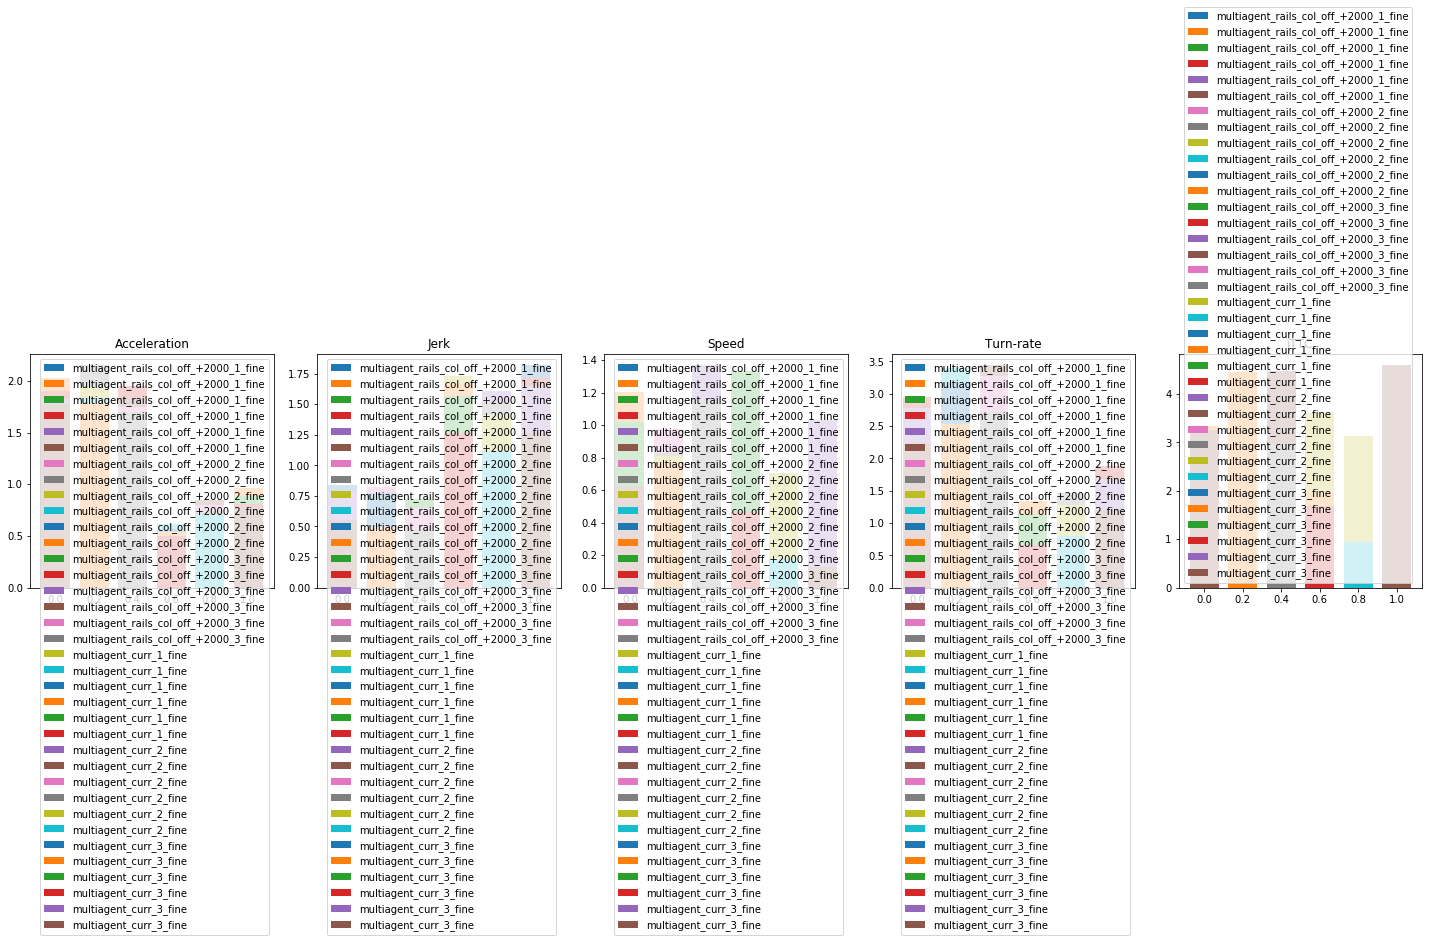

In [19]:
do_plots(model_divs)

In [20]:
def do_plots_2(emergent_values, sorted_order, name='emergent2'):
    plt.figure(figsize=(20,4))
    attr_width = .2
    for i, model in enumerate(sorted_order):
        divs = emergent_values[model]
        attr_keys = sorted(emergent_values[model].keys())
        for j, attr in enumerate(attr_keys):
            plt.subplot(1,len(attr_keys),j+1)
            plt.title(attr)
            div = divs[attr]
            plt.bar(i*attr_width, div, width=.15, label=model)
            if i == len(emergent_values) - 1:
                plt.legend()
    plt.savefig(name+'.png')
    plt.tight_layout()

0750am-0805am
0805am-0820am
0820am-0835am
0400-0415
0500-0515
0515-0530


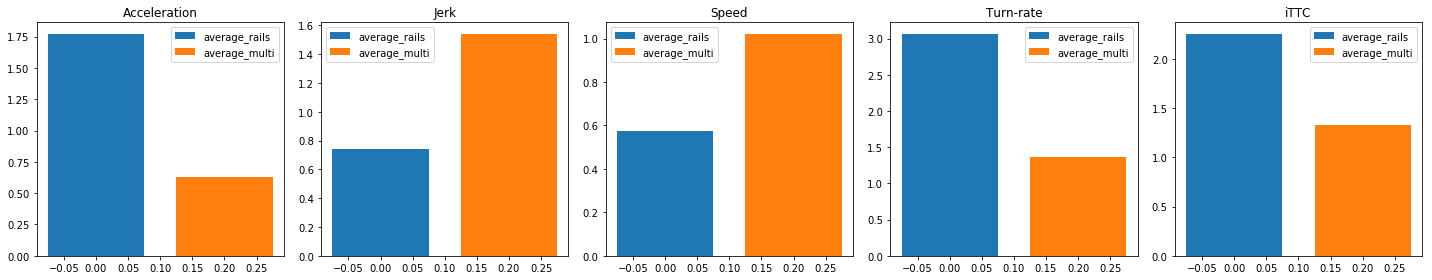

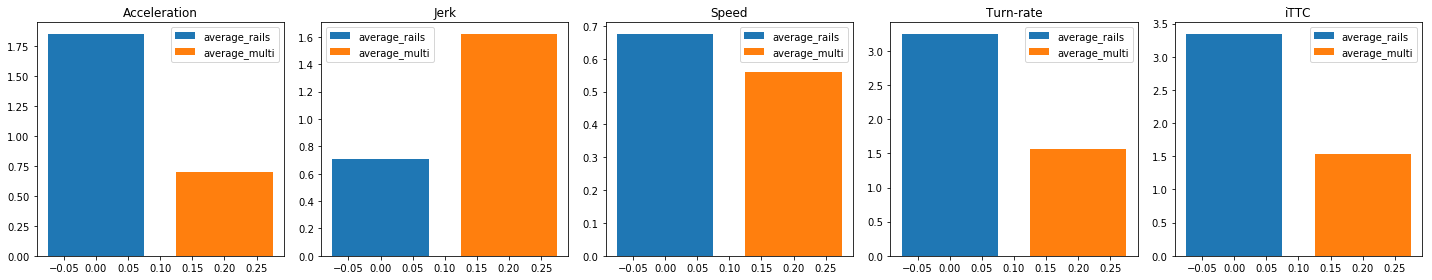

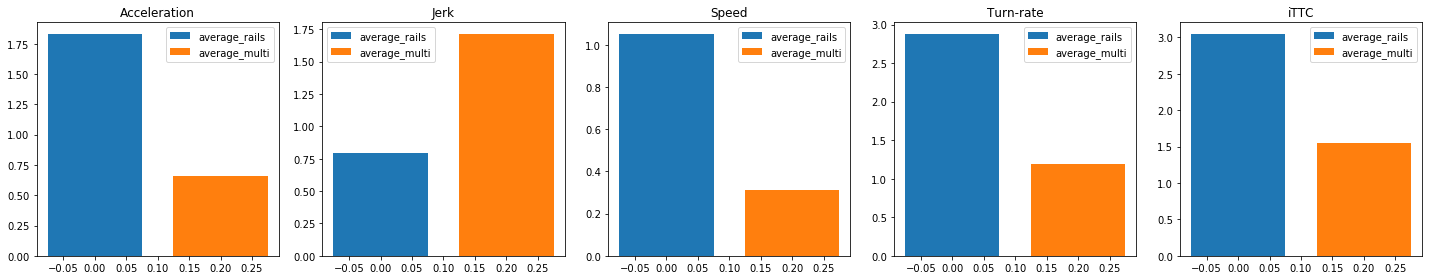

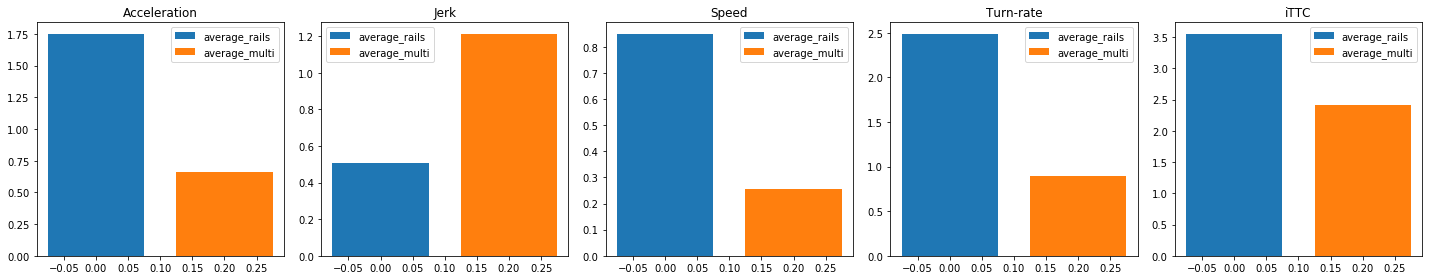

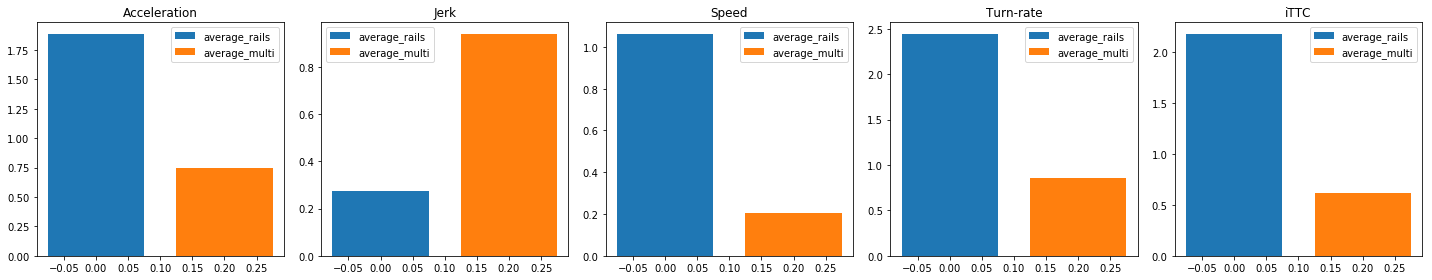

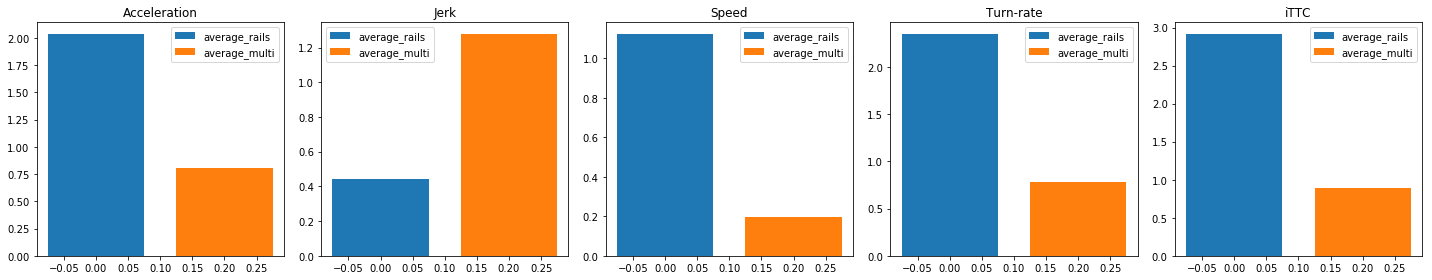

In [21]:

ngsim_labels = traj_lab_dict[model_labels[0]][1]

for t in ngsim_labels:
    print(t)
    model_divs_avg = dict()
    model_divs_avg['average_rails'] = dict()
    model_divs_avg['average_multi'] = dict()
    for attr in model_divs[0][t].keys():
        model_divs_avg['average_rails'][attr] = np.mean([model_divs[i][t][attr] \
                                                            for i, label in enumerate(model_labels) \
                                                              if 'rails' in label])
        model_divs_avg['average_multi'][attr] = np.mean([model_divs[i][t][attr]\
                                                            for i, label in enumerate(model_labels) \
                                                              if not 'rails' in label])
    avg_sorted_order = ['average_rails', 'average_multi']
    do_plots_2(model_divs_avg, avg_sorted_order, 'emergent_avg_'+t)
    

0805am-0820am
0820am-0835am
{'average_multi': {'Speed': 0.43577242174691766, 'Jerk': 1.6709092401079304, 'Turn-rate': 1.3729670933144633, 'iTTC': 1.5411560782691673, 'Acceleration': 0.68175792588606332}, 'average_rails': {'Speed': 0.86580010777926608, 'Jerk': 0.75290820775757594, 'Turn-rate': 3.0714533084228419, 'iTTC': 3.2011940672795367, 'Acceleration': 1.8455802343348902}}


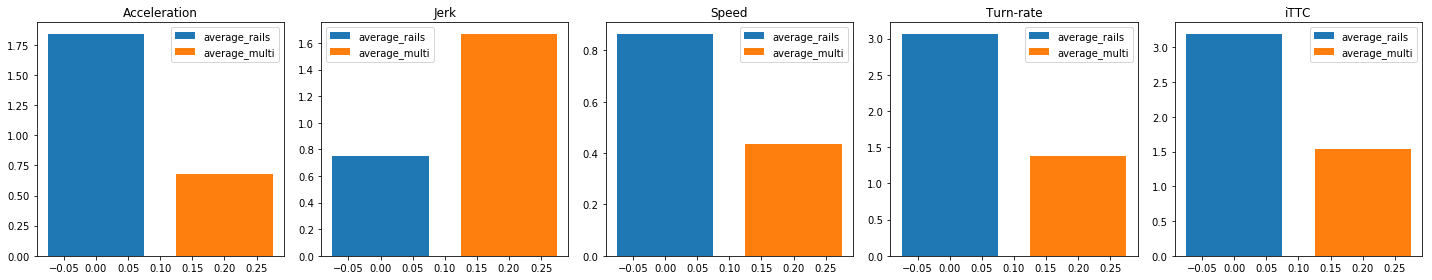

In [22]:

ngsim_labels = traj_lab_dict[model_labels[0]][1]

to_average = ['0805am-0820am', '0820am-0835am']
n = len(to_average)


model_divs_avg = dict()
model_divs_avg['average_rails'] = dict()
model_divs_avg['average_multi'] = dict()

for t in to_average:
    print(t)
    for attr in model_divs[0][t].keys():
        if attr in model_divs_avg['average_rails'].keys():
            model_divs_avg['average_rails'][attr] += np.mean([model_divs[i][t][attr] \
                                                                for i, label in enumerate(model_labels) \
                                                                  if 'rails' in label])/n
            model_divs_avg['average_multi'][attr] += np.mean([model_divs[i][t][attr]\
                                                                for i, label in enumerate(model_labels) \
                                                                  if not 'rails' in label])/n
        else:
            model_divs_avg['average_rails'][attr] = np.mean([model_divs[i][t][attr] \
                                                                for i, label in enumerate(model_labels) \
                                                                  if 'rails' in label])/n
            model_divs_avg['average_multi'][attr] = np.mean([model_divs[i][t][attr]\
                                                                for i, label in enumerate(model_labels) \
                                                                  if not 'rails' in label])/n
avg_sorted_order = ['average_rails', 'average_multi']
print(model_divs_avg)
do_plots_2(model_divs_avg, avg_sorted_order, 'emergent_avg_'+'_'.join(to_average))
    

0400-0415
0500-0515
0515-0530


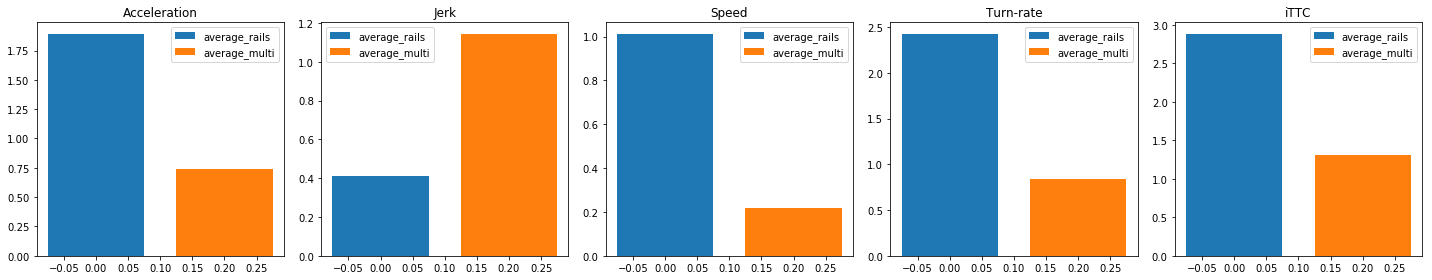

In [23]:

ngsim_labels = traj_lab_dict[model_labels[0]][1]

to_average = ['0400-0415', '0500-0515', '0515-0530']
n = len(to_average)

model_divs_avg = dict()
model_divs_avg['average_rails'] = dict()
model_divs_avg['average_multi'] = dict()

for t in to_average:
    print(t)
    for attr in model_divs[0][t].keys():
        if attr in model_divs_avg['average_rails'].keys():
            model_divs_avg['average_rails'][attr] += np.mean([model_divs[i][t][attr] \
                                                                for i, label in enumerate(model_labels) \
                                                                  if 'rails' in label])/n
            model_divs_avg['average_multi'][attr] += np.mean([model_divs[i][t][attr]\
                                                                for i, label in enumerate(model_labels) \
                                                                  if not 'rails' in label])/n
        else:
            model_divs_avg['average_rails'][attr] = np.mean([model_divs[i][t][attr] \
                                                                for i, label in enumerate(model_labels) \
                                                                  if 'rails' in label])/n
            model_divs_avg['average_multi'][attr] = np.mean([model_divs[i][t][attr]\
                                                                for i, label in enumerate(model_labels) \
                                                                  if not 'rails' in label])/n

avg_sorted_order = ['average_rails', 'average_multi']
do_plots_2(model_divs_avg, avg_sorted_order, 'emergent_avg_'+'_'.join(to_average))
    

# We also want to compute actual emergent values
These are: Lane change rate, Offroad duration, Collision Rate, and Hard Brake Rate

The above graph is for KL divergence of features, which is not the same as the emergent characteristics of the dataset.

In [24]:
def calc_offroad(traj, thresh = -1.0):
    num_offroad = float(len(traj['observations'][:,0][
        np.where(np.minimum(traj['observations'][:,observation_indexes['distance_road_edge_left']], 
                            traj['observations'][:,observation_indexes['distance_road_edge_right']]) <= thresh)
        ]))
    return num_offroad / float(len(traj['observations']))

def calc_hard_brake(traj, thresh = -3.0):
    #traj should be unnormalized
    return float(len(traj['observations'][:,observation_indexes['accel']][np.where(\
                traj['observations'][:,observation_indexes['accel']] <= thresh)])) \
                / float(len(traj['actions']))

def calc_collisions(traj, expert=True, H=200, nveh=100):
    if expert:
        return float(len(traj['observations'][:,observation_indexes['is_colliding']][
            np.where(np.isclose(traj['observations'][:,observation_indexes['is_colliding']],1))
        ]))/ float(len(traj['observations']))
    else:
        a = np.reshape(traj['observations'][:,observation_indexes['is_colliding']], (H, nveh))[:50,:]
        return np.mean(np.any(np.isclose(a, 1.0), axis=1))



In [25]:
def count_num_lane_change(single_traj_d_right, lane_width=3.0, max_jump=1.5, verbose=False):
    num = 0.0
    i = 0
    d0 = single_traj_d_right[0]
    while i < len(single_traj_d_right):
        indxs = np.argwhere(abs(single_traj_d_right[i:] - d0) >= lane_width)
        if verbose:
            print("indxs", indxs)
            print(i)
            print("old d0", d0)
        if len(indxs) == 0: 
            return num
        i += indxs[0][0]
        d0 = single_traj_d_right[i]
        if verbose:
            print(i)
            print(d0)
        if i > 0 and abs(d0 - single_traj_d_right[i-1]) <= max_jump:
            if verbose: print("increase")
            num += 1
    return num

def test_count_num_lane_change():
    single_traj = np.array([0,1.5])
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1, verbose=False) == 0
    single_traj = np.array([0,1,1.5])
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1, verbose=False) == 1

    single_traj = np.array([0,0,0.5,1.1,1,1,1.5,\
                   2.0,2.6,2.4,3.0,\
                  1,2,1.5,2,2.5])
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1) == 3
    single_traj[-1] = 2.4
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1) == 2
    single_traj[-1] = 2.6
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1) == 3

    single_traj = np.array([0,0,5,5,5,5.5,6.5,\
                   2.5,2.6,2.4,3.0,3.6,4.0,\
                  1,2,1.5,2,2.5])
    assert count_num_lane_change(single_traj, lane_width=1.5, max_jump=1, verbose=False) == 3
    
test_count_num_lane_change()

def calc_lane_change(traj):
    num_lane_change = count_num_lane_change(traj['observations'][:,observation_indexes['distance_road_edge_left']])
    return num_lane_change / float(len(traj['observations']))

In [26]:
# Some other specific metrics we want
HARD_BRAKE_THRESH = -3.0
expert_emergent_values = dict()
for time_period in expert.keys():
    print(time_period)
    expert_emergent_values[time_period] = dict()
    expert_emergent_values[time_period]['Collision Rate'] = calc_collisions(expert[time_period])
    expert_emergent_values[time_period]['Offroad Duration'] = calc_offroad(expert[time_period])
    expert_emergent_values[time_period]['Hard Brake Rate'] = calc_hard_brake(expert[time_period],
                                                                                 thresh = HARD_BRAKE_THRESH)
    #expert_emergent_values[time_period]['Lane Change Rate'] = calc_lane_change(expert[time_period])
    #print(expert_emergent_values[time_period]['Lane Change Rate'])


0820am-0835am
0515-0530
0500-0515
0805am-0820am
0750am-0805am
0400-0415


# Run the below 3 cells after redefining the models

### Small disclaimer that lane change rate is calculated very slowly... 
you may want to run without to start, it isn't super useful. Then start it up and go watch a movie, and maybe it'll be done when you come back :)

In [27]:
ngsim_labels = traj_lab_dict[model_labels[0]][1]
N_VEH = 100
sorted_order = ['expert']
sorted_order.extend([i for i in sorted(model_labels) if 'rails' in i])
sorted_order.extend([i for i in sorted(model_labels) if not 'rails' in i])
print(sorted_order)

emergent_values = dict()

for t, t_label in enumerate(ngsim_labels):
    print(t_label)
    emergent_values[t_label] = dict()
    emergent_values[t_label]['expert'] = expert_emergent_values[t_label]
    for label in model_labels:
        print(label)
        trajs = traj_lab_dict[label][0][t]
        emergent_values[t_label][label] = dict()
        emergent_values[t_label][label]['Hard Brake Rate'] = np.mean([calc_hard_brake(scene, thresh = HARD_BRAKE_THRESH
                                                                           ) for scene in trajs])
        emergent_values[t_label][label]['Offroad Duration'] = np.mean([calc_offroad(scene) for scene in trajs])
        emergent_values[t_label][label]['Collision Rate'] = np.mean([calc_collisions(scene, expert=True, nveh=N_VEH) for scene in trajs])
        #emergent_values[t_label][label]['Lane Change Rate'] = np.mean([calc_lane_change(scene) for scene in trajs])

    #do_plots_2(emergent_values[t_label], sorted_order, 'emergent_2_'+t_label)

['expert', 'multiagent_rails_col_off_+2000_1_fine', 'multiagent_rails_col_off_+2000_2_fine', 'multiagent_rails_col_off_+2000_3_fine', 'multiagent_curr_1_fine', 'multiagent_curr_2_fine', 'multiagent_curr_3_fine']
0750am-0805am
multiagent_rails_col_off_+2000_1_fine
multiagent_rails_col_off_+2000_2_fine
multiagent_rails_col_off_+2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0805am-0820am
multiagent_rails_col_off_+2000_1_fine
multiagent_rails_col_off_+2000_2_fine
multiagent_rails_col_off_+2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0820am-0835am
multiagent_rails_col_off_+2000_1_fine
multiagent_rails_col_off_+2000_2_fine
multiagent_rails_col_off_+2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0400-0415
multiagent_rails_col_off_+2000_1_fine
multiagent_rails_col_off_+2000_2_fine
multiagent_rails_col_off_+2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0500

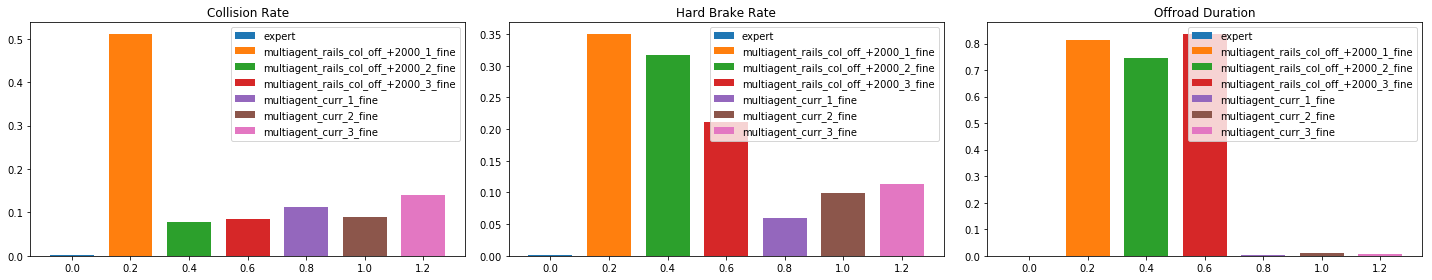

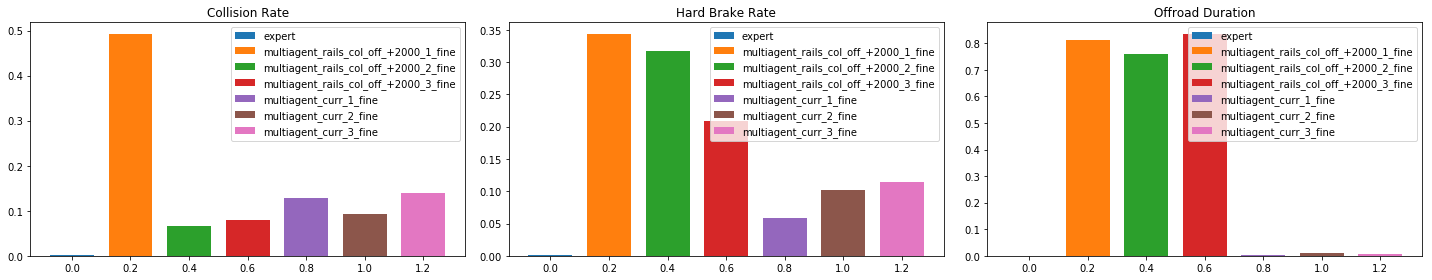

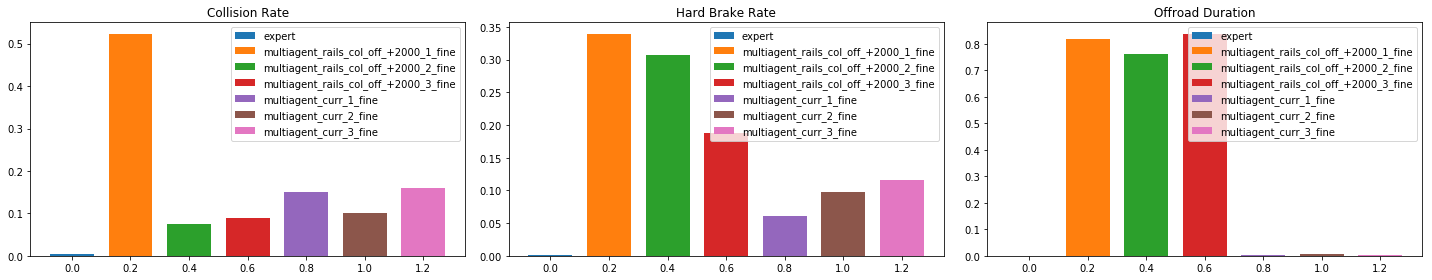

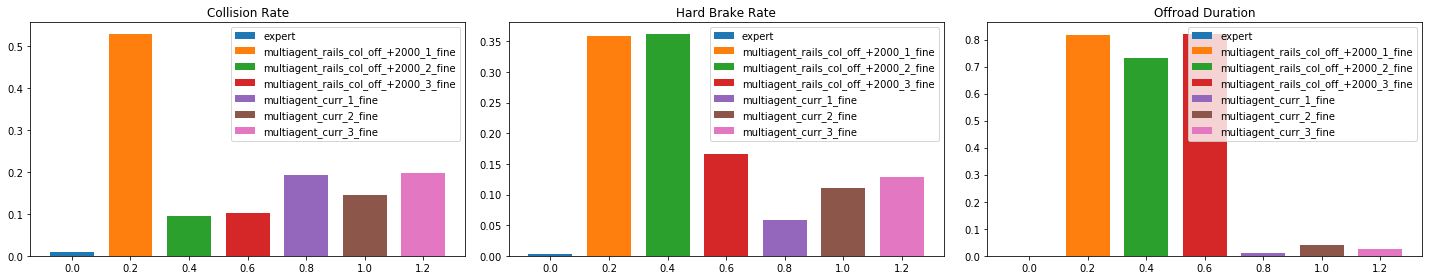

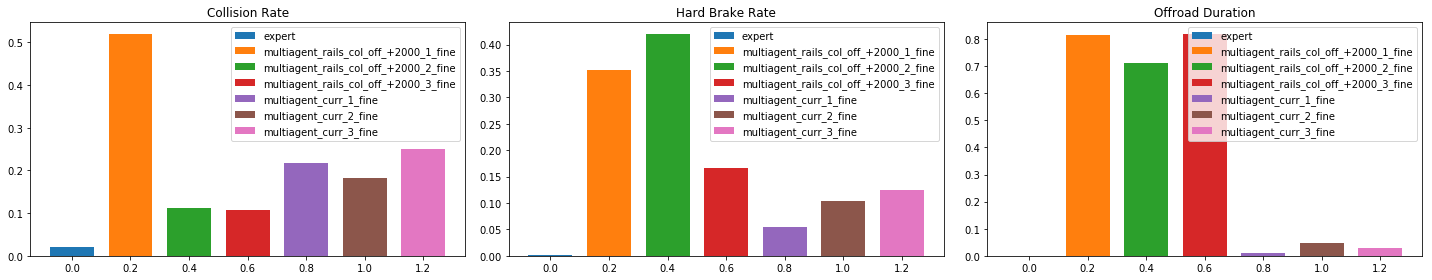

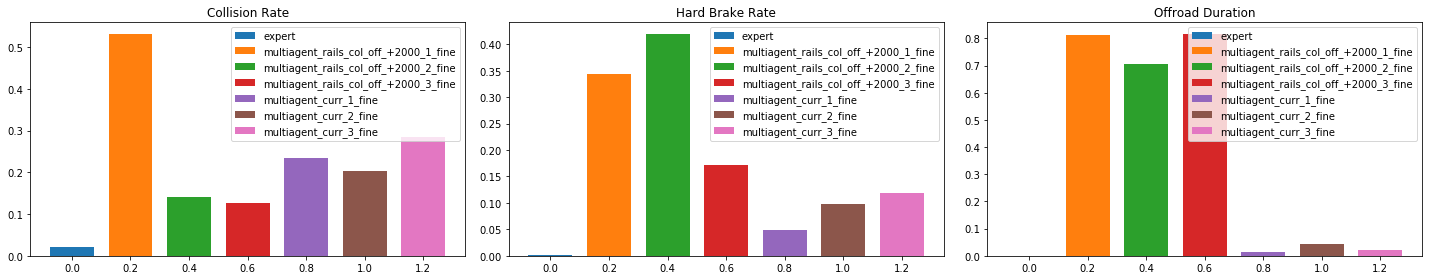

In [28]:
for t in ngsim_labels:
    do_plots_2(emergent_values[t], sorted_order, 'emergent_2_'+t)

0750am-0805am
0805am-0820am
0820am-0835am
0400-0415
0500-0515
0515-0530


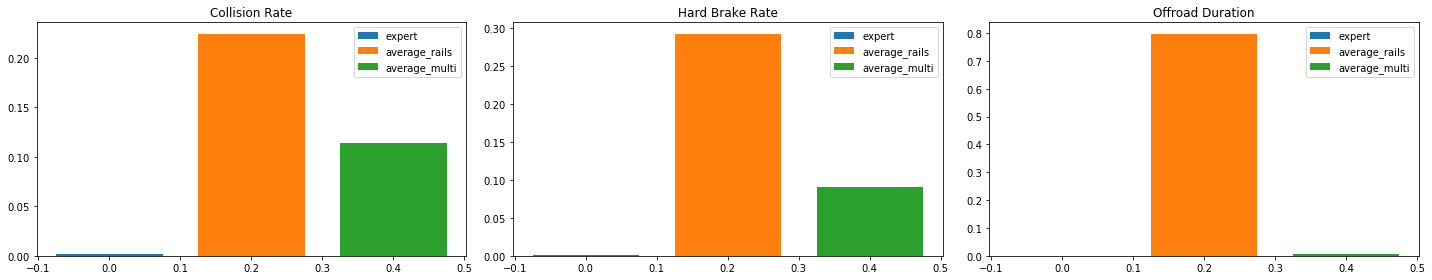

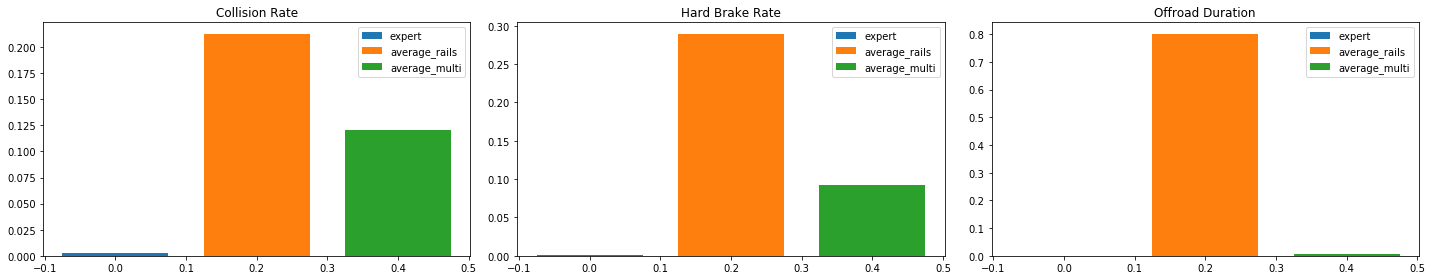

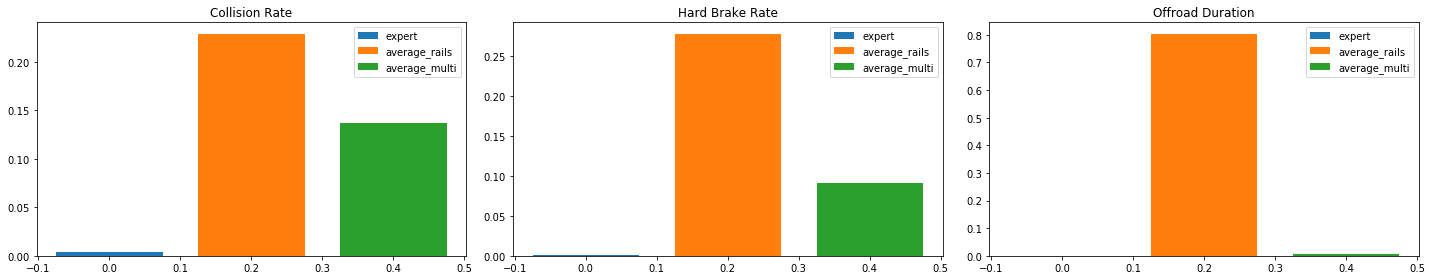

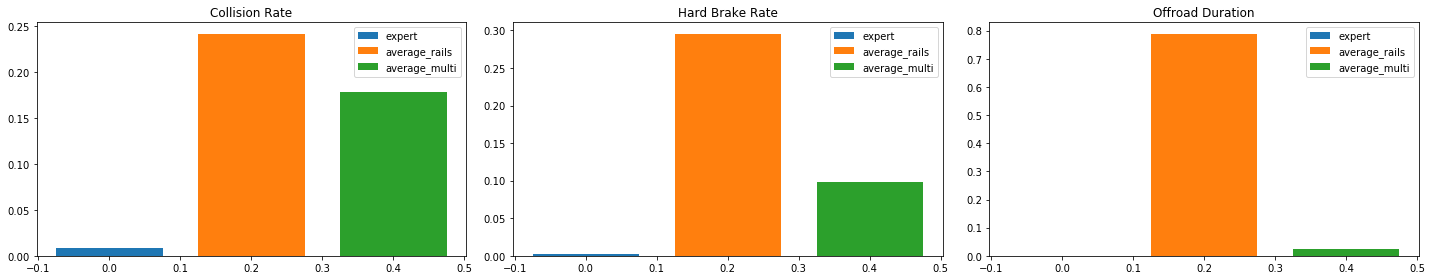

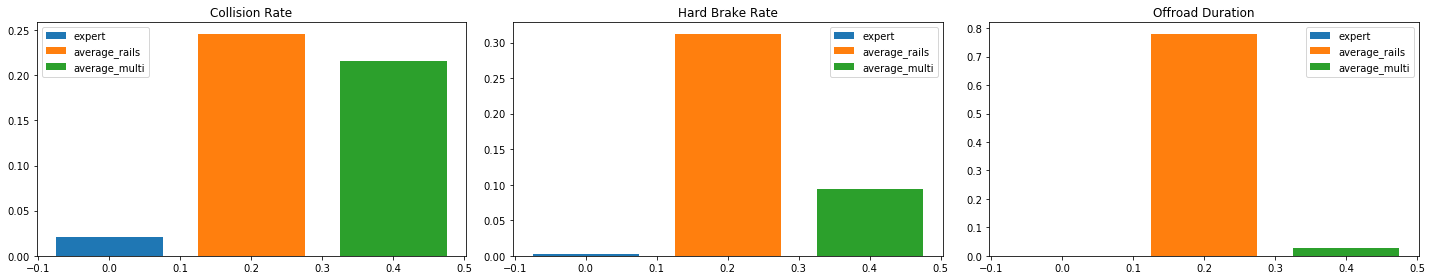

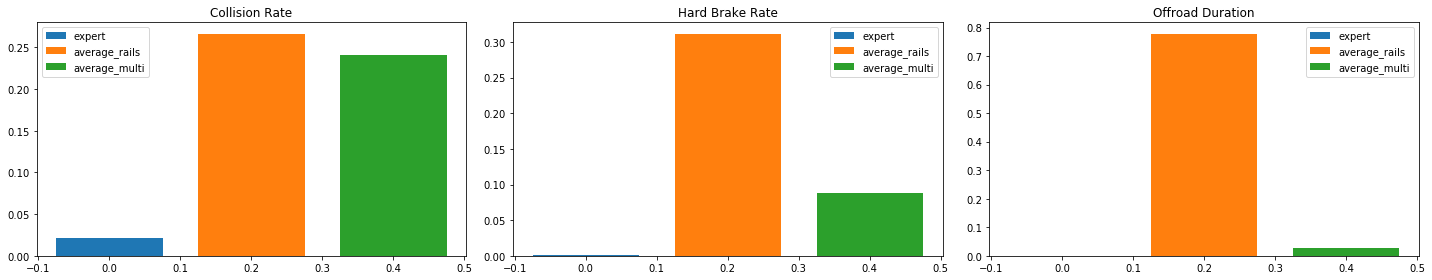

In [29]:
avg_sorted_order = ['expert', 'average_rails', 'average_multi']
average_emergent_values = dict()
for t, t_label in enumerate(ngsim_labels):
    print(t_label)
    average_emergent_values[t_label] = dict()
    average_emergent_values[t_label]['expert'] = expert_emergent_values[t_label]
    average_emergent_values[t_label]['average_rails'] = dict()
    average_emergent_values[t_label]['average_multi'] = dict()

    for attr in average_emergent_values[t_label]['expert'].keys():
        average_emergent_values[t_label]['average_rails'][attr] = np.mean([emergent_values[t_label][label][attr] \
                                                                   for label in model_labels if 'rails' in label])
        average_emergent_values[t_label]['average_multi'][attr] = np.mean([emergent_values[t_label][label][attr]\
                                                                 for label in model_labels if not 'rails' in label])
    do_plots_2(average_emergent_values[t_label], avg_sorted_order, 'emergent_avg2_'+t_label)

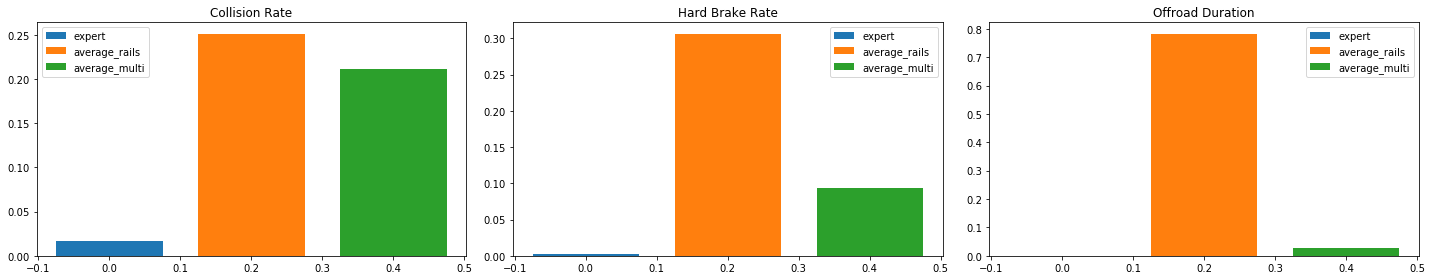

In [30]:
to_average = ['0400-0415', '0500-0515', '0515-0530']
n = len(to_average)

label = "_".join(to_average)
val_average_emergent_values = dict()
val_average_emergent_values[label] = dict()

for model in avg_sorted_order:
    val_average_emergent_values[label][model] = dict()
    for attr in average_emergent_values[to_average[0]][model].keys():
        val_average_emergent_values[label][model][attr] = np.mean([average_emergent_values[t][model][attr] \
                                                               for t in to_average])

do_plots_2(val_average_emergent_values[label], avg_sorted_order, 'emergent_avg2_'+label)

{'average_multi': {'Offroad Duration': 0.0059895416666666673, 'Hard Brake Rate': 0.091492916666666674, 'Collision Rate': 0.12876104166666666}, 'expert': {'Offroad Duration': 0.00027219020088058924, 'Collision Rate': 0.0028326091871748783, 'Hard Brake Rate': 0.00086541716090410118}, 'average_rails': {'Offroad Duration': 0.80375250000000009, 'Hard Brake Rate': 0.28410174999999999, 'Collision Rate': 0.22114841666666671}}


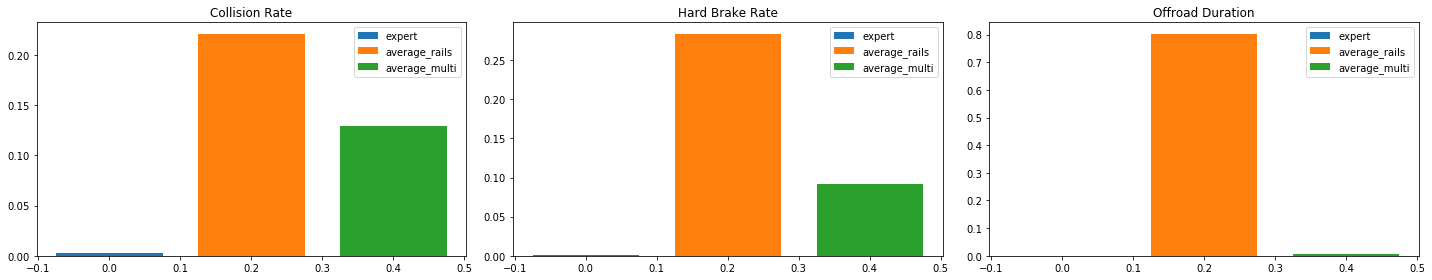

In [31]:
to_average = ['0805am-0820am', '0820am-0835am']

n = len(to_average)

label = "_".join(to_average)

val_average_emergent_values[label] = dict()

for model in avg_sorted_order:
    val_average_emergent_values[label][model] = dict()
    for attr in average_emergent_values[to_average[0]][model].keys():
        val_average_emergent_values[label][model][attr] = np.mean([average_emergent_values[t][model][attr] \
                                                               for t in to_average])

print(val_average_emergent_values[label])
do_plots_2(val_average_emergent_values[label], avg_sorted_order, 'emergent_avg2_'+label)

# testing

In [35]:
for key,value in val_average_emergent_values[label].items():
    print(key, ", ", value["Offroad Duration"])




average_multi ,  0.00598954166667
average_rails ,  0.74145575
expert ,  0.000272190200881


In [36]:
def calc_offroad(traj, thresh = -1.0):
    return float(len(traj['observations'][:,observation_indexes['out_of_lane']][
        np.where(np.isclose(traj['observations'][:,observation_indexes['out_of_lane']],1))
    ]))/ float(len(traj['observations']))

ngsim_labels = traj_lab_dict[model_labels[0]][1]
N_VEH = 100
sorted_order = ['expert']
sorted_order.extend([i for i in sorted(model_labels) if 'rails' in i])
sorted_order.extend([i for i in sorted(model_labels) if not 'rails' in i])
print(sorted_order)

emergent_values = dict()

for t, t_label in enumerate(ngsim_labels):
    print(t_label)
    emergent_values[t_label] = dict()
    emergent_values[t_label]['expert'] = expert_emergent_values[t_label]
    for label in model_labels:
        print(label)
        trajs = traj_lab_dict[label][0][t]
        emergent_values[t_label][label] = dict()
        emergent_values[t_label][label]['Hard Brake Rate'] = np.mean([calc_hard_brake(scene, thresh = HARD_BRAKE_THRESH
                                                                           ) for scene in trajs])
        emergent_values[t_label][label]['Offroad Duration'] = np.mean([calc_offroad(scene) for scene in trajs])
        emergent_values[t_label][label]['Collision Rate'] = np.mean([calc_collisions(scene, expert=True, nveh=N_VEH) for scene in trajs])
        #emergent_values[t_label][label]['Lane Change Rate'] = np.mean([calc_lane_change(scene) for scene in trajs])

    #do_plots_2(emergent_values[t_label], sorted_order, 'emergent_2_'+t_label)

['expert', 'multiagent_rails_col_2000_1_fine', 'multiagent_rails_col_2000_2_fine', 'multiagent_rails_col_2000_3_fine', 'multiagent_curr_1_fine', 'multiagent_curr_2_fine', 'multiagent_curr_3_fine']
0750am-0805am
multiagent_rails_col_2000_1_fine
multiagent_rails_col_2000_2_fine
multiagent_rails_col_2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0805am-0820am
multiagent_rails_col_2000_1_fine
multiagent_rails_col_2000_2_fine
multiagent_rails_col_2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0820am-0835am
multiagent_rails_col_2000_1_fine
multiagent_rails_col_2000_2_fine
multiagent_rails_col_2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0400-0415
multiagent_rails_col_2000_1_fine
multiagent_rails_col_2000_2_fine
multiagent_rails_col_2000_3_fine
multiagent_curr_1_fine
multiagent_curr_2_fine
multiagent_curr_3_fine
0500-0515
multiagent_rails_col_2000_1_fine
multiagent_rails_col_2000_2_fine
mul

0750am-0805am
0805am-0820am
0820am-0835am
0400-0415
0500-0515
0515-0530
{'average_multi': {'Offroad Duration': 0.0045778750000000003, 'Hard Brake Rate': 0.091492916666666674, 'Collision Rate': 0.12876104166666666}, 'average_rails': {'Offroad Duration': 0.74364750000000002, 'Hard Brake Rate': 0.30060433333333336, 'Collision Rate': 0.015865916666666667}, 'expert': {'Offroad Duration': 0.00027219020088058924, 'Hard Brake Rate': 0.00086541716090410118, 'Collision Rate': 0.0028326091871748783}}


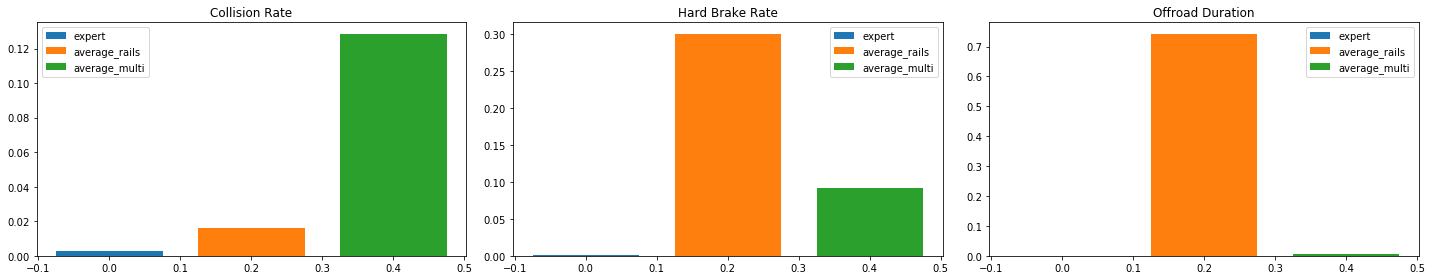

In [37]:
avg_sorted_order = ['expert', 'average_rails', 'average_multi']
average_emergent_values = dict()
for t, t_label in enumerate(ngsim_labels):
    print(t_label)
    average_emergent_values[t_label] = dict()
    average_emergent_values[t_label]['expert'] = expert_emergent_values[t_label]
    average_emergent_values[t_label]['average_rails'] = dict()
    average_emergent_values[t_label]['average_multi'] = dict()

    for attr in average_emergent_values[t_label]['expert'].keys():
        average_emergent_values[t_label]['average_rails'][attr] = np.mean([emergent_values[t_label][label][attr] \
                                                                   for label in model_labels if 'rails' in label])
        average_emergent_values[t_label]['average_multi'][attr] = np.mean([emergent_values[t_label][label][attr]\
                                                                 for label in model_labels if not 'rails' in label])
    #do_plots_2(average_emergent_values[t_label], avg_sorted_order, 'emergent_avg2_'+t_label)

to_average = ['0805am-0820am', '0820am-0835am']

n = len(to_average)

label = "_".join(to_average)

val_average_emergent_values[label] = dict()

for model in avg_sorted_order:
    val_average_emergent_values[label][model] = dict()
    for attr in average_emergent_values[to_average[0]][model].keys():
        val_average_emergent_values[label][model][attr] = np.mean([average_emergent_values[t][model][attr] \
                                                               for t in to_average])

print(val_average_emergent_values[label])
do_plots_2(val_average_emergent_values[label], avg_sorted_order, 'emergent_avg2_'+label)

In [38]:
for key,value in val_average_emergent_values[label].items():
    print(key, ", ", value["Offroad Duration"])



average_multi ,  0.004577875
average_rails ,  0.7436475
expert ,  0.000272190200881
